In [106]:
'''
Machine Learning for Public Policy Spring 2018
University of Chicago

Date: 15th May 2018

Amir Akhter Kazi
kazi@uchicago.edu
'''

'\nMachine Learning for Public Policy Spring 2018\nUniversity of Chicago\n\nDate: 15th May 2018\n\nAmir Akhter Kazi\nkazi@uchicago.edu\n'

In [144]:
'''
IMPORTANT:
The code to run this file is at the very end. 
'''

'\nIMPORTANT:\nThe code to run this file is at the very end. \n'

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
from sklearn.svm import SVC
from scipy import optimize
import time





%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### READING DATA

In [4]:
def reading_file (filename, index = 0):
    '''
    Given the name of the file and index column, reads the file,
        and uses the index as the index_column (where applicable)
    File type has to be csv, json, xls or xlsx. 
        
        
    input:
        filename: string
        index: string
            default index is 0, when index is not provided.
        
    returns: dataframe
    
    Further documentation:
        https://www.tutorialspoint.com/python/string_endswith.htm
    '''
    if filename.endswith('csv'):
        df = pd.read_csv(filename, index_col = index)
    elif filename.endswith('xls') or filename.endswith('xlsx'):
        df = pd.read_excel(filename, index_col = index)
    elif filename.endswith('json'):
        df = pd.read_json(filename)
    else:
        raise ValueError ('File type not supported')
    
    return df

### PRE-PROCESSING & CLEANING DATA

In [5]:
def checking_for_nulls(dataframe):
    '''
    Given a dataframe, checks for columns which have NaN or Nulls,
        and returns a list with the name of those features which have NaN or Nulls.
        
    Input:
        dataframe
        
    Output:
        features_with_nulls: list of strings
    '''
    features = dataframe.columns
    features_with_nulls = []

    for column in df.columns:    
        if df[column].isnull().sum() > 0:
            features_with_nulls.append(column)
    
    return features_with_nulls

In [6]:
def fill_in_missing_data (dataframe, criteria):
    '''
    Given a dataframe and a criteria (options: mean, median or mode),
        fills in the NaN or Null values in that column for the dataframe
        based on the given criteria
        
    Input:
        dataframe
        criteria: string
    '''
    features_with_nulls = checking_for_nulls(dataframe)
    
    for feature in features_with_nulls:
        if criteria == 'mean': input_value = df[feature].mean() 
        if criteria == 'median': input_value = df[feature].median() 
        if criteria == 'mode': input_value = float(df[feature].mode())
        
        dataframe[feature] = dataframe[feature].fillna(input_value)
            


In [7]:
def removing_outliers (dataframe):
    '''
    For a given dataframe, loops over the features 
        and removes any rows which have an outlier for any given feature
    Uses the removing_outliers_helper function in its task
    
    input: dataframe
    
    output: dataframe (with outliers removed)
    '''
    df = dataframe.columns
    
    for feature in df:
        dataframe = removing_outliers_helper(dataframe, feature)
        
    return dataframe

In [8]:
def removing_outliers_helper (dataframe, feature, upper_quartile = 0.995, lower_quartile = 0.005):
    '''
    For a given dataframe and feature,
        removes those rows which are outliers (i.e. above the 99.5 percentile, or below the 0.5 percentile)
        
    Returns the dataframe after removing those rows
    
    Input: 
        dataframe
        feature: string
        
    Output:
        returns dataframe (with outliers of a feature removed)
        
    Inspired by:
    https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles/35828995
    '''

    upper_bound = dataframe[feature].quantile(upper_quartile)
    lower_bound = dataframe[feature].quantile(lower_quartile)
    dataframe = dataframe.loc[(dataframe[feature] >= lower_bound) & (dataframe[feature] <= upper_bound)]

    return dataframe

### EXPLORING DATA 

In [9]:
def basic_exploring (dataframe):
    '''
    Given a dataframe, the function does some basic exploring
        by printing the description and information of the dataset
        
    input:
        dataframe
    '''
    print ('DESCRIBING DATASET: \n \n', dataframe.describe(), '\n \n') 
    print ('DATASET INFORMATION \n') 
    print (df.info(), '\n \n \n')
    print ('DATASET HEAD \n')
    print (df.head(), '\n \n \n')
    print ('DATASET TAIL \n')
    print (df.tail(), '\n \n \n')
    
    for column in df.columns:
        plotting_curves (df, column)
        plt.show()

In [10]:
def draw_correlation_matrix (df, title):
    '''
    Creates a heatmap that shows the correlations between the different variables in a dataframe.
    
    Input:
        df: a dataframe
        title: name of the correlation_matrix
        
    Return:
        Outputs a heatmatrix showing correlations
    
    Code based on: https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
    '''
    ax = plt.axes()
    corr = df.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values, ax = ax) 
    ax.set_title (title)

In [11]:
def plotting_curves (dataframe, feature):
    '''
    Given a dataframe, a column name, 
        displays a plot of that dataframe column distribution.
        
    Input:
        dataframe
        feature: column name (string)
        
    Return:
        displays a distribution of that variable
        
    Inspired by:
        https://seaborn.pydata.org/generated/seaborn.distplot.html
    '''
    title = feature + ' Graph'
    ax = sns.distplot(dataframe[feature])
    ax.set_title(title)

In [12]:
def splitting_across_variable(dataframe, feature):
    '''
    For a given dataframe and feature,
        it splits the database as per the values of the feature,
        and gives aggregrate information for that feature and
        how it relates to other features
        
    Input:
        dataframe
        
    Output: 
        dataframe
    '''
    return dataframe.groupby([feature]).mean().transpose()

In [13]:
def value_counter (dataframe, feature):
    '''
    Given a dataframe, and feature,
        gives the number of occurrences of each value in that feature column
        
    Input:
        dataframe
        feature: string
    
    Output: dataframe
    '''
    return dataframe[feature].value_counts()

In [14]:
def comparing_two_features(dataframe, feature_1, feature_2):
    '''
    Given a dataframe, and two features,
        does a cross tab and shows values across those two corresponding features
        
    Input:
        dataframe
        feature_1, feature_2: string
        
    Output: 
        dataframe
        
    '''
    return pd.crosstab(dataframe[feature_1], dataframe[feature_2])

In [15]:
def plotting_two_feature_comparison(dataframe, x_feature, y_feature):
    '''
    Given a dataframe and two features,
        plots a graph across those two features
        
    Input:
        dataframe
        x_feature, y_feature: string
        
    Output:
        matplotlib.axes._subplots.AxesSubplot
    '''
    return dataframe[[x_feature, y_feature]].groupby(x_feature).sum().plot()

### GENERATING FEATURES/PREDICTORS

In [16]:
def discretizing_feature (dataframe, feature, number_of_bins):
    '''
    Given a dataframe and a feature,
        changes continuous values of that feature into different categories.
    Drops the original feature column. 
    Names the new discretized feature as feature + 'discrete'
    
    Input:
        dataframe
        feature: string
        number_of_bins: int
        
    output:
        dataframe
        
    Further documentation:    
        https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
        https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
    '''
    dataframe[feature + '_discrete'] = pd.cut (dataframe[feature], number_of_bins, include_lowest = True, labels = range(0,number_of_bins))
    dataframe.drop([feature], inplace=True, axis=1)
    return dataframe
    

In [17]:
def converting_to_dummy (dataframe, feature):
    '''
    Given a dataframe and a feature,
        creates a dummy column for the feature column, and drops the old feature columns
        from the dataframe
        
    Input:
        dataframe
        feature: string
        
    Output:
        dataframe
    
    Further documentation:
        https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
        https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40
    '''
    
    # creates a new dataframe with dummies
    dummy = pd.get_dummies(dataframe[feature]).rename(columns=lambda x: str(feature)+ '_' + str(x))
    # concatenating new dataframe with old dataframe
    dataframe = pd.concat([dataframe, dummy], axis = 1)
    # dropping old feature columns from dataframe
    dataframe.drop([feature], inplace=True, axis=1)
    
    return dataframe
    

### SPLITTING TRAINING AND TESTING DATA

In [18]:
def splitting_data(dataframe, y):
    '''
    Given a dataframe, and y (independent variable),
        makes a list of dependent variables, 
        and does a train, test split 
        
    Input:
        dataframe
        y: string
        
    return:
        X_train, X_test, y_train, y_test (dataframes)
        
    Further documentation:
        https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.to_frame.html
        http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    '''
    X = list(dataframe.columns) 
    X.remove(y)
    
    dependent = dataframe[X]
    #try:
    #    independent = pd.Series.to_frame(dataframe[y])
    #except:
    independent = dataframe[y]
    X_train, X_test, y_train, y_test =  train_test_split(dependent, independent, test_size = 0.1, random_state = 1234)
    
    return X_train, X_test, y_train, y_test

### BUILDING CLASSIFIER

In [19]:
# Taken from Rayid's Magic Loop, and edited where appropriate
# https://github.com/rayidghani/magicloops/blob/master/simpleloop.py

def plotting_plot_precision_recall(y_test, y_pred_probs, model, para = None):
    '''
    Given inputs of predicted and actual y values on a model,
        plots a graph of precision vs recall
        
    Input:
        y_test
        y_pred_pobs
        model: string
        
    Output:
        prints plot
        
    
    '''
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve for {} model: AUC={:.2f} \n with parameters: {}'.\
                        format(model, average_precision_score(y_test, y_pred_probs), para))
    plt.show()

In [20]:
# Taken from Rayid's Magic Loop, and edited where appropriate
# https://github.com/rayidghani/magicloops/blob/master/simpleloop.py

def  generate_binary_at_k (y_scores, k):
    '''
    Given a k, will create a binary to decide if the y_score should be a 0 or 1
    
    Input:
        y_scores,
        k
        
    Output:
        test_predictions_binary 
    '''
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary

In [21]:
# Taken from Rayid's Magic Loop, and edited where appropriate
# https://github.com/rayidghani/magicloops/blob/master/simpleloop.py

def scores_at_k(y_true, y_scores, k):
    '''
    Given a k, returns f1 score, precision and recall
    
    Input:
        y_true
        y_scores
        k
        
    Output:
        f1
        precision
        recall
    '''
    preds_at_k = generate_binary_at_k(y_scores, k)
    f1 = f1_score(y_true, preds_at_k)
    precision = precision_score(y_true, preds_at_k)
    recall = recall_score(y_true, preds_at_k)

    return precision, recall, f1

In [22]:
# Taken from Rayid's Magic Loop, and edited where appropriate
# https://github.com/rayidghani/magicloops/blob/master/simpleloop.py

def clf_loop(models_to_run, x_train, x_test, y_train, y_test):
    '''
    Given the training and test set, along with the type of model,
        tests, trains and runs the model and plots the precision recall graph.
    Also inputs results of AUC, precision, F1 score, recall etc to a dataframe.
    '''
    results_df = pd.DataFrame(columns=('model_type', 'parameters', 'accuracy','auc-roc', 'auc-pr', 'time', 'precision,recall,f1 at_1','precision,recall,f1 at_2','precision,recall,f1 at_5','precision,recall,f1 at_10','precision,recall,f1 at_20',
     'precision,recall,f1 at_30', 'precision,recall,f1 at_50'))
    for index, clf in enumerate([clfs[x] for x in models_to_run]):
        model_params = small_grid[models_to_run[index]]
        for p in ParameterGrid(model_params):
            try:
                start = time.time()
                clf.set_params(**p)
                y_pred_probs = clf.fit(x_train, y_train).predict_proba(x_test)[:,1]
                accuracy = clf.score(x_test, y_test)
                end = time.time()
                #Zip, unzip to ensure corresponding order
                y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))

                results_df.loc[len(results_df)] = [models_to_run[index], p, accuracy,
                                                    roc_auc_score(y_test, y_pred_probs),
                                                    average_precision_score(y_test, y_pred_probs), end-start,                                                     
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,1.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,2.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,20.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,30.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,50.0)]

                plotting_plot_precision_recall(y_test, y_pred_probs, models_to_run[index], p)
 
            except IndexError as e:
                print(e)
                continue

    return results_df

In [23]:
# Taken from Rayid's Magic Loop, and edited where appropriate
# https://github.com/rayidghani/magicloops/blob/master/simpleloop.py

clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
    'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
    'LR': LogisticRegression(penalty='l1', C=1e5),
    'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
    'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
    'NB': GaussianNB(),
    'DT': DecisionTreeClassifier(),
    'SGD': SGDClassifier(loss="hinge", penalty="l2"),
    'KNN': KNeighborsClassifier(n_neighbors=3) 
        }

In [24]:
# Taken from Rayid's Magic Loop, and edited where appropriate
# https://github.com/rayidghani/magicloops/blob/master/simpleloop.py

small_grid = { 
'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
'ET': { 'n_estimators': [10,100], 'criterion' : ['gini', 'entropy'] ,'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
'GB': {'n_estimators': [10,100], 'learning_rate' : [0.001,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [5,50]},
'NB' : {},
'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
       }

# CODE TO RUN IT 

In [28]:
#### RUN THIS


#### READING DATA ####

file_name = 'credit-data.csv'
index_col = 'PersonID'

df = reading_file (file_name, index_col)






In [29]:
#### RUN THIS


#### PRE-PROCESSING & CLEANING DATA ####
fill_in_missing_data(df, 'mean')
df = removing_outliers (df)

DESCRIBING DATASET: 
 
        SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines           age  \
count      39243.000000                          39243.000000  39243.000000   
mean           0.153199                              0.349186     51.679255   
std            0.360184                              0.367977     14.491125   
min            0.000000                              0.000000     23.000000   
25%            0.000000                              0.033492     41.000000   
50%            0.000000                              0.181690     51.000000   
75%            0.000000                              0.644008     62.000000   
max            1.000000                              1.617530     89.000000   

            zipcode  NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  \
count  39243.000000                          39243.000000  39243.000000   
mean   60623.821650                              0.299442    283.852846   
std       11.988968                    

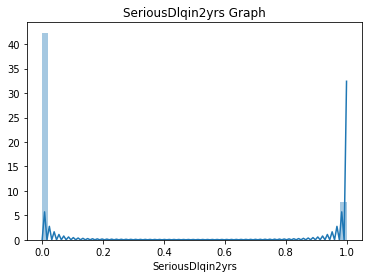

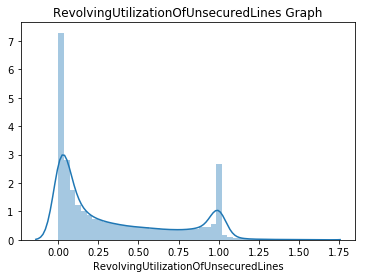

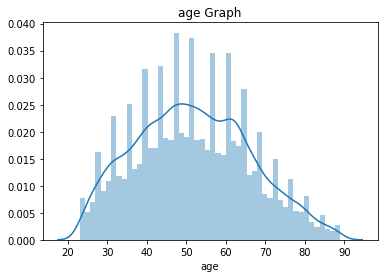

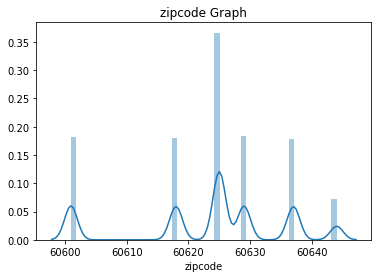

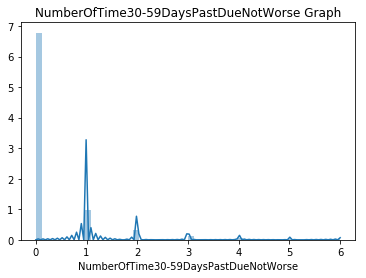

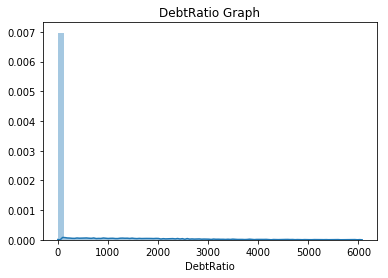

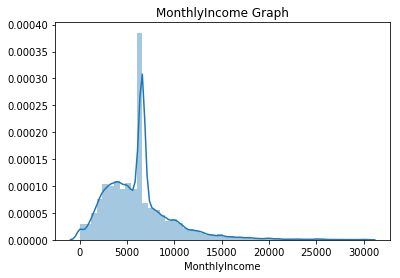

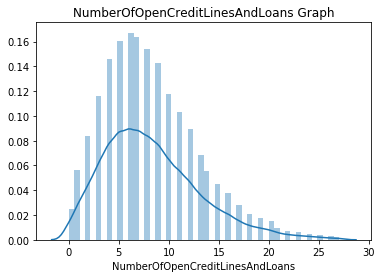

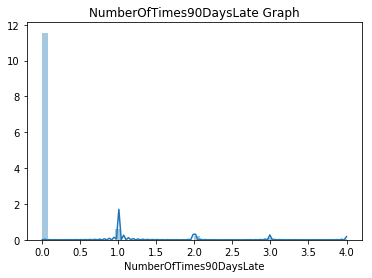

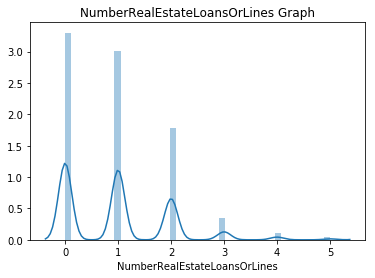

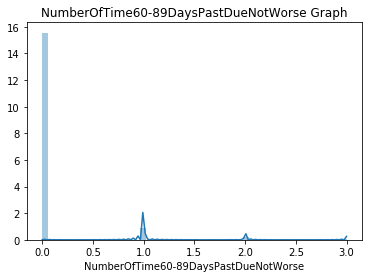

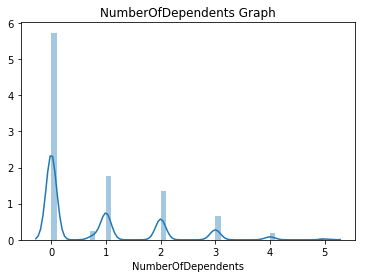

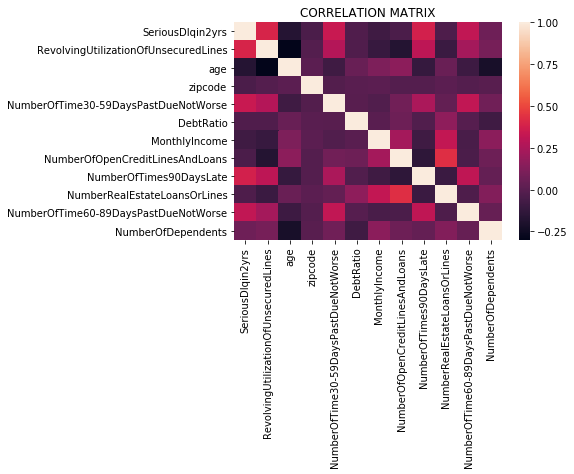

In [30]:
#### RUN THIS

#### EXPLORING DATA ####

basic_exploring(df)
print ('\n \n \n')
draw_correlation_matrix(df, 'CORRELATION MATRIX')



In [31]:
#### RUN THIS

#### EXPLORING DATA ####

for feature in df.columns:
    if df[feature].nunique() < 20:
        #print (splitting_across_variable(df, feature))
        print (value_counter(df, feature))

0    33231
1     6012
Name: SeriousDlqin2yrs, dtype: int64
60625    12362
60629     6174
60601     6152
60618     6059
60637     6043
60644     2453
Name: zipcode, dtype: int64
0    31933
1     4666
2     1561
3      613
4      282
5      132
6       56
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64
0    36274
1     1876
2      659
3      302
4      132
Name: NumberOfTimes90DaysLate, dtype: int64
0    15063
1    13765
2     8134
3     1568
4      529
5      184
Name: NumberRealEstateLoansOrLines, dtype: int64
0    36625
1     2028
2      447
3      143
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64
0.000000    22481
1.000000     6965
2.000000     5341
3.000000     2567
0.773231      952
4.000000      749
5.000000      188
Name: NumberOfDependents, dtype: int64


In [32]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'zipcode', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'],
      dtype='object')

In [33]:
#### RUN THIS

#### EXPLORING DATA ####
for feature in df.columns:
    print (comparing_two_features(df, feature, 'SeriousDlqin2yrs'))

SeriousDlqin2yrs      0     1
SeriousDlqin2yrs             
0                 33231     0
1                     0  6012
SeriousDlqin2yrs                         0    1
RevolvingUtilizationOfUnsecuredLines           
0.000000                              2528  181
0.000008                                 1    0
0.000013                                 1    0
0.000014                                 1    0
0.000015                                 1    0
0.000016                                 1    0
0.000019                                 1    0
0.000019                                 1    0
0.000027                                 1    0
0.000028                                 1    0
0.000032                                 1    0
0.000032                                 1    0
0.000034                                 1    0
0.000034                                 1    0
0.000040                                 1    0
0.000043                                 1    0
0.000047        

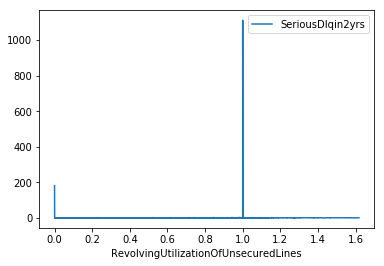

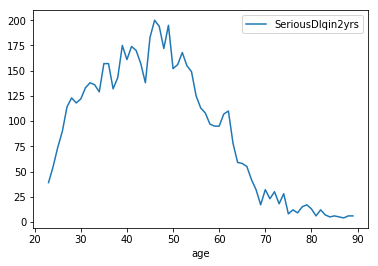

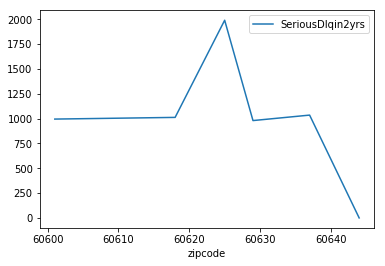

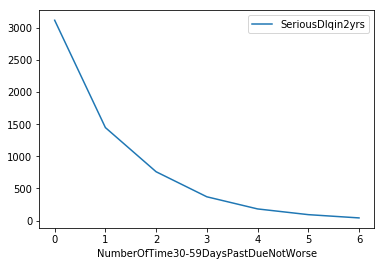

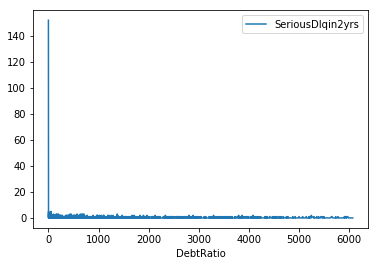

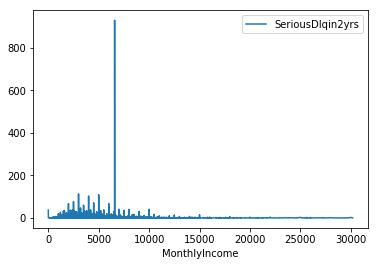

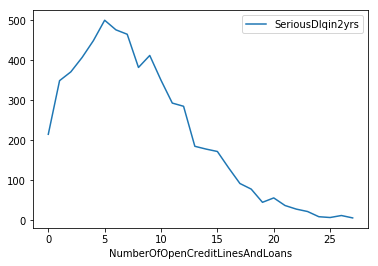

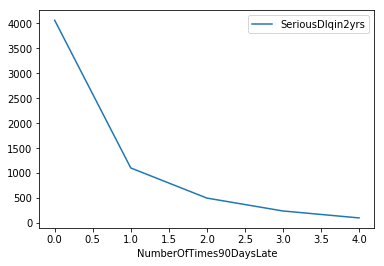

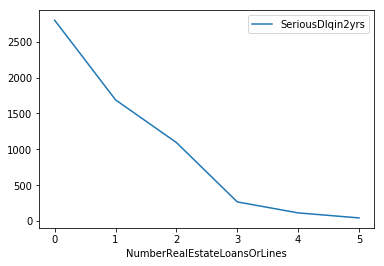

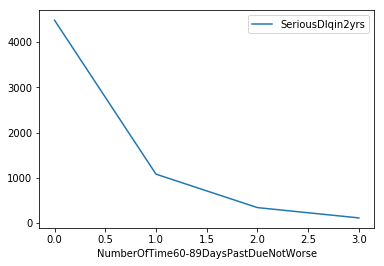

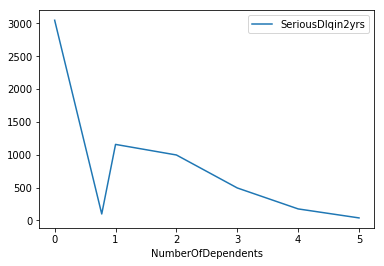

In [34]:
#### RUN THIS

#### EXPLORING DATA ####
for feature in list(df.columns):
    if feature != 'SeriousDlqin2yrs':
        plotting_two_feature_comparison(df, feature, 'SeriousDlqin2yrs')

In [35]:
#### RUN THIS

#### GENERATING FEATURES/PREDICTORS ####
variables_to_discretize = ['age','NumberOfTime30-59DaysPastDueNotWorse','MonthlyIncome', 'NumberRealEstateLoansOrLines', 'NumberOfOpenCreditLinesAndLoans' ]

for feature in variables_to_discretize:
    discretizing_feature (df, feature, 4)
    
variables_to_dummy = ['zipcode']
for feature in variables_to_dummy:
    df = converting_to_dummy (df, feature)

In [36]:
#### RUN THIS


#dataframe = df
y = 'SeriousDlqin2yrs'
x_train, x_test, y_train, y_test = splitting_data(df, y)

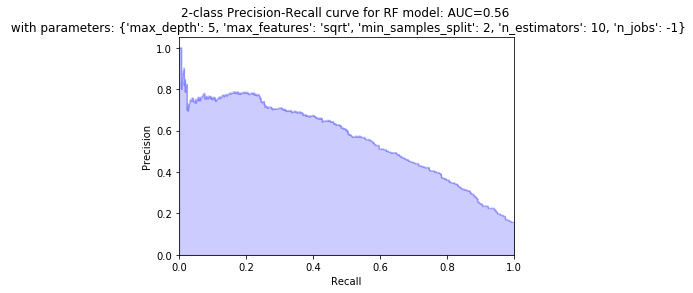

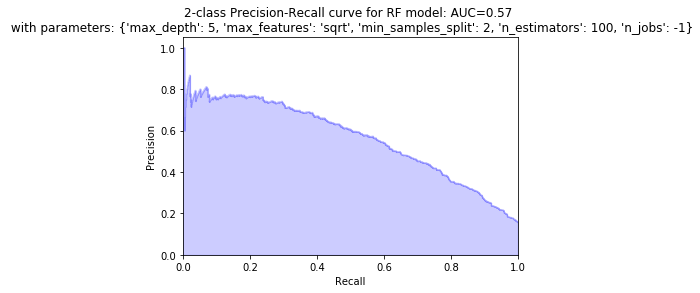

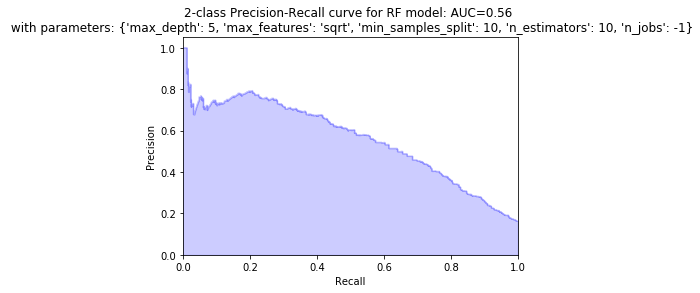

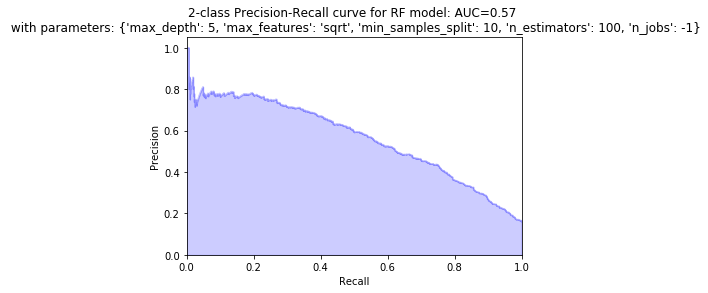

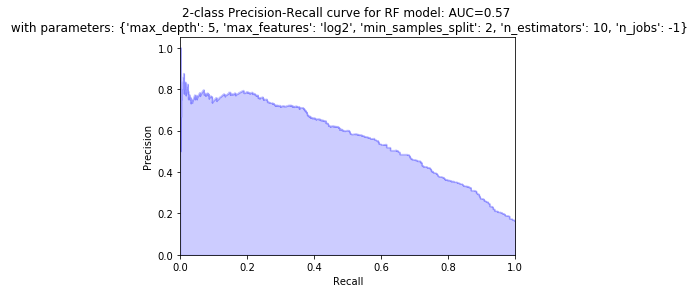

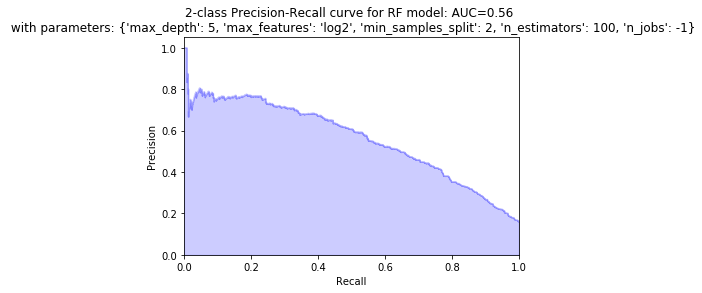

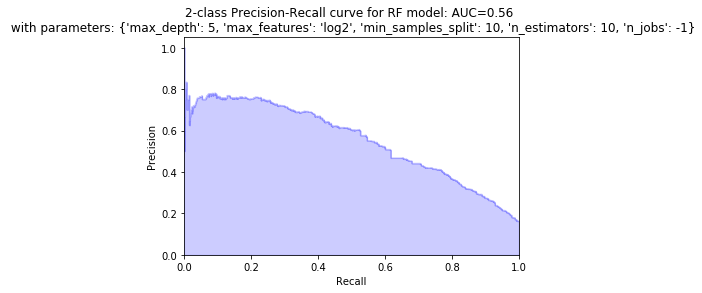

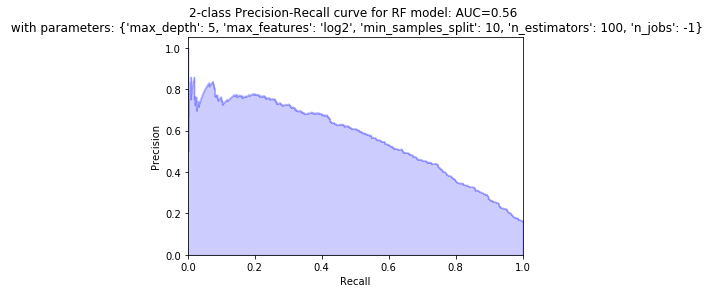

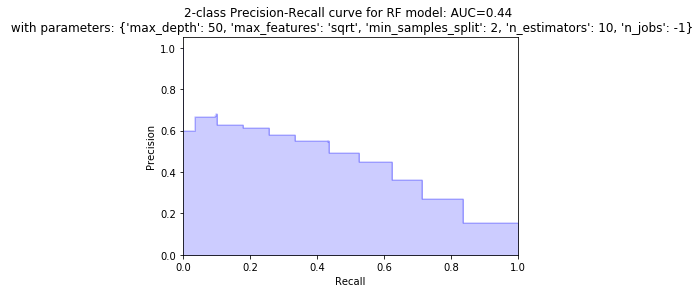

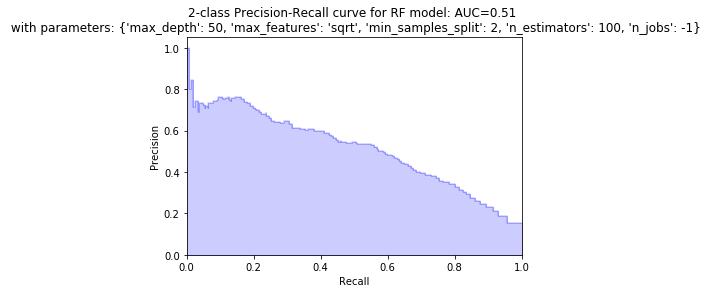

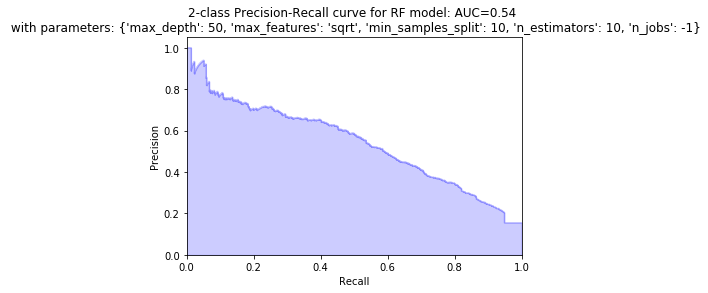

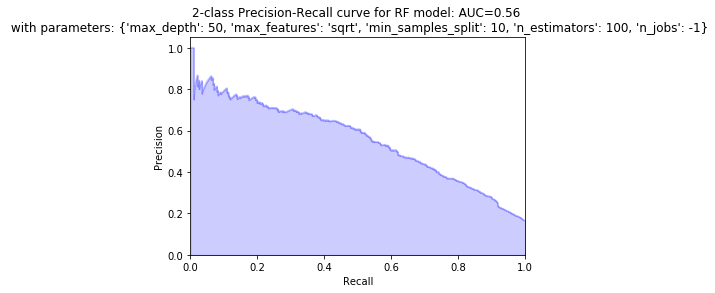

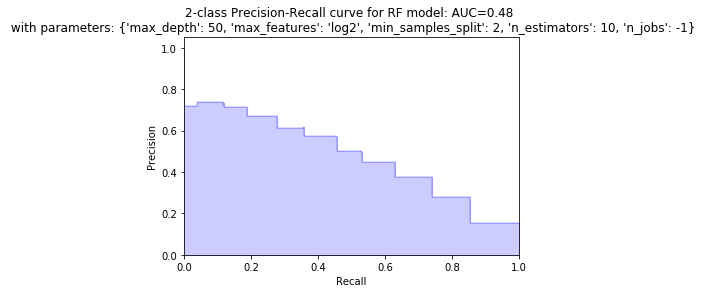

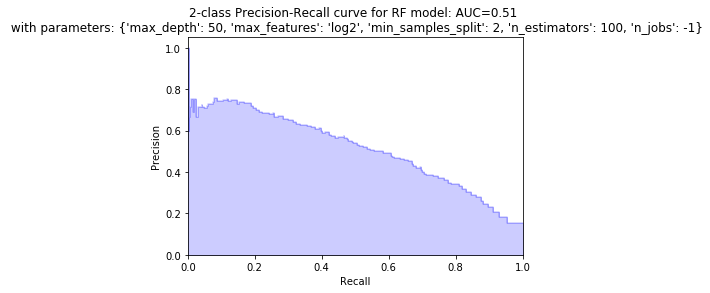

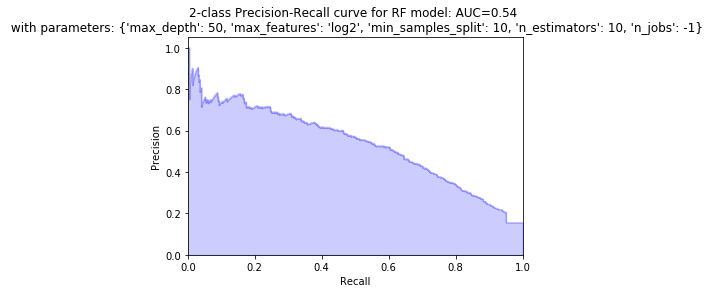

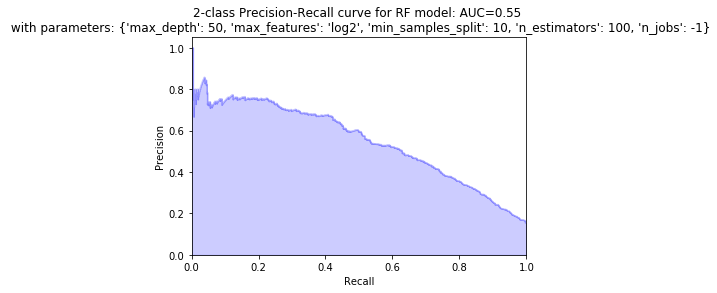

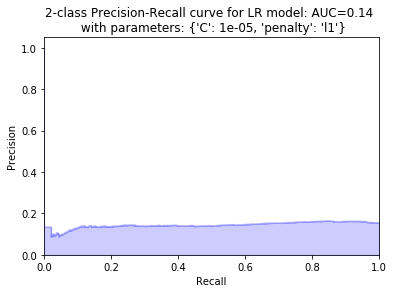

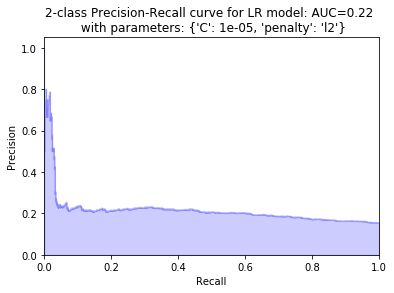

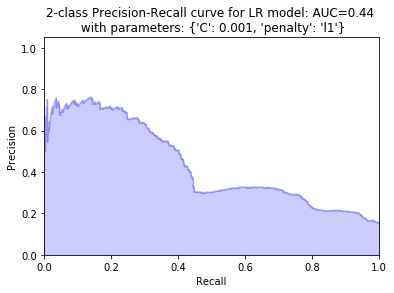

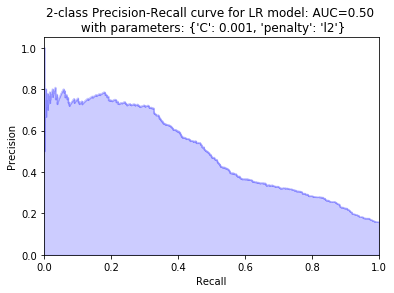

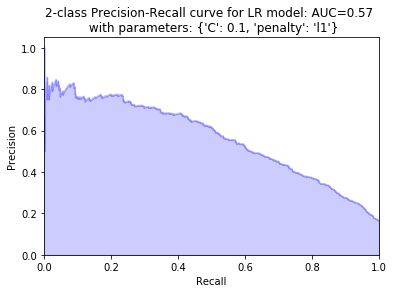

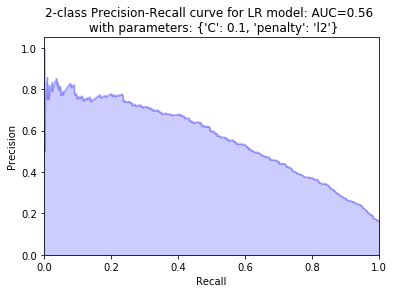

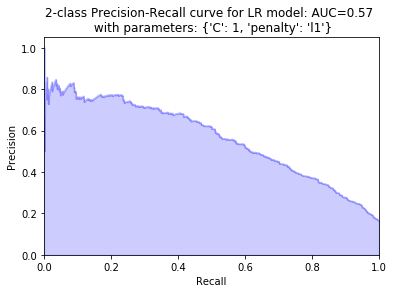

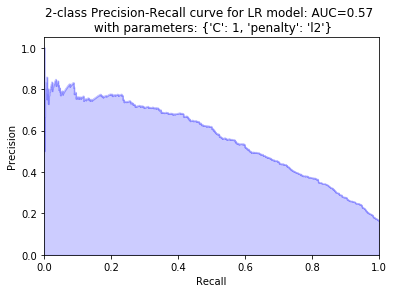

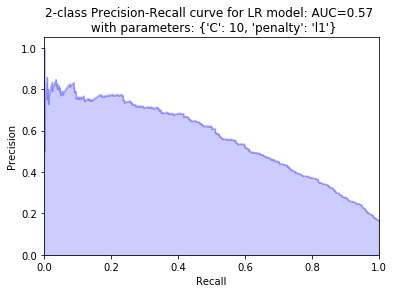

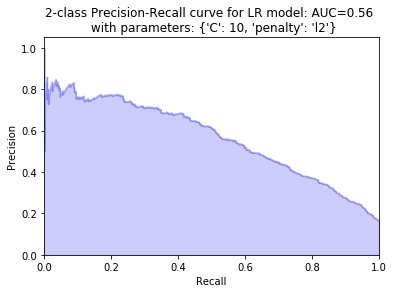

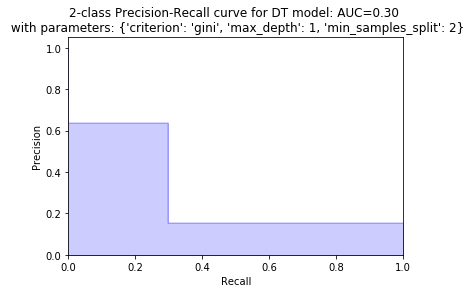

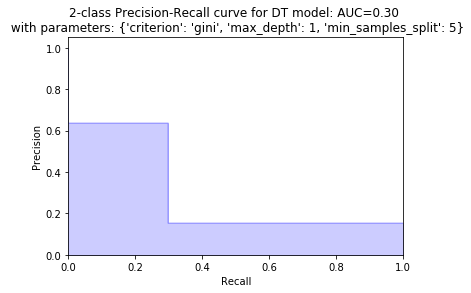

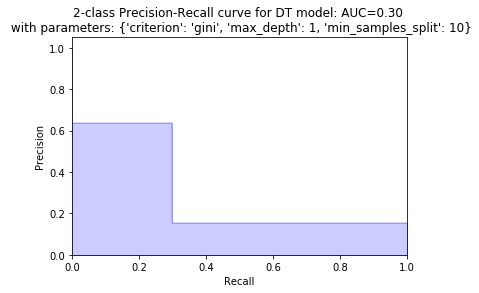

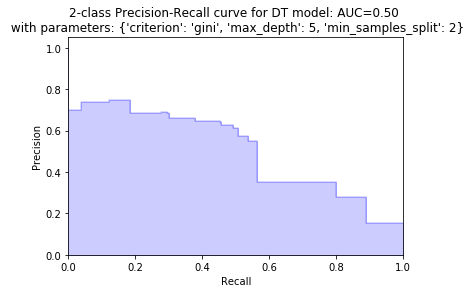

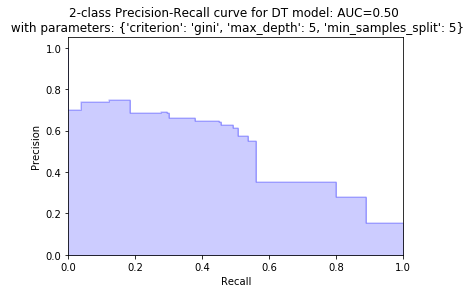

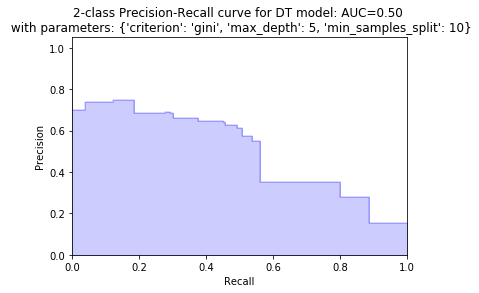

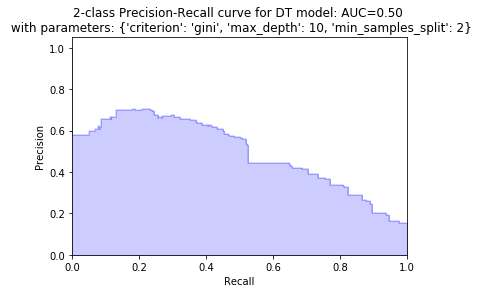

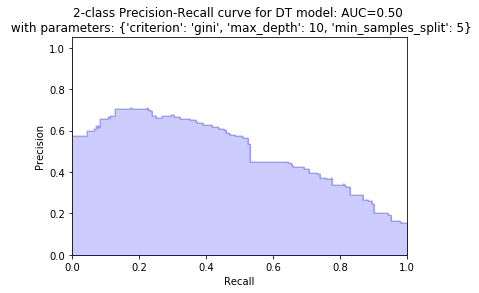

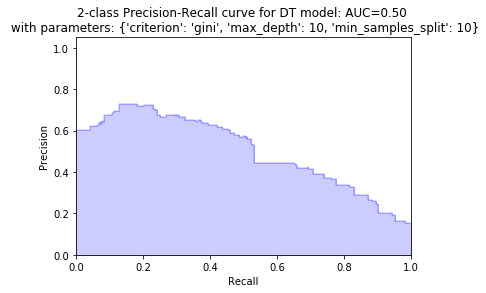

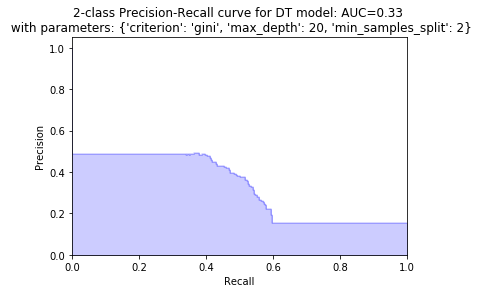

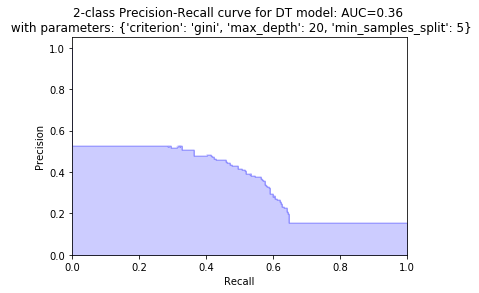

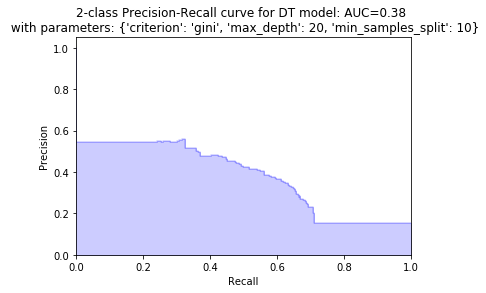

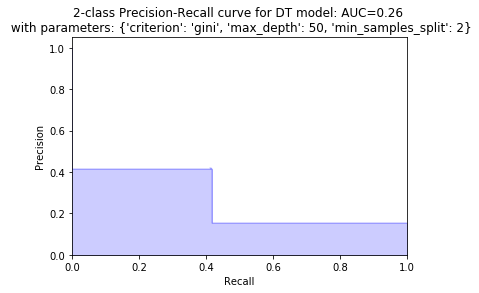

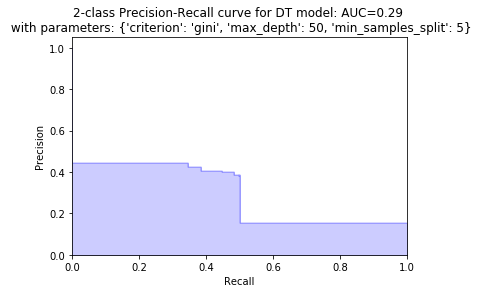

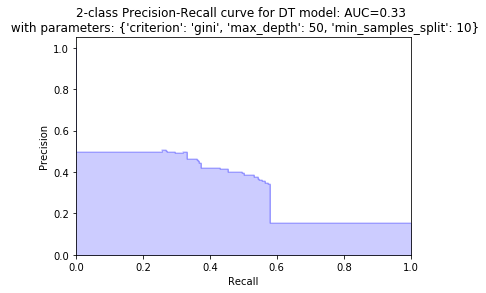

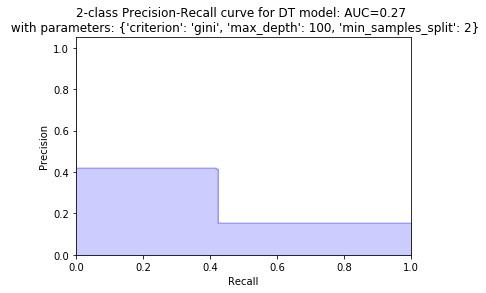

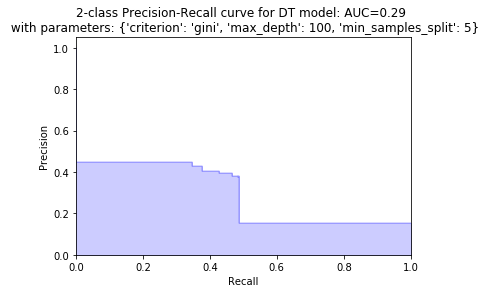

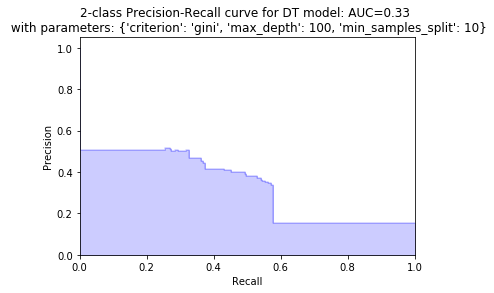

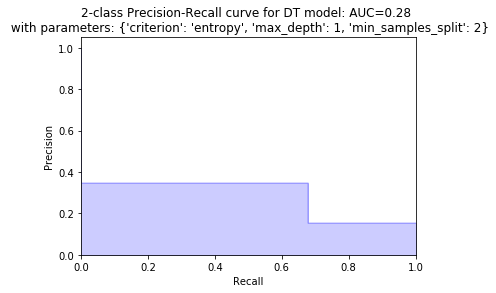

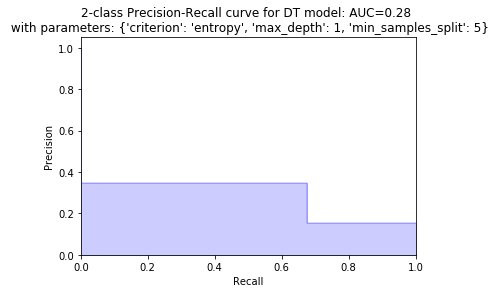

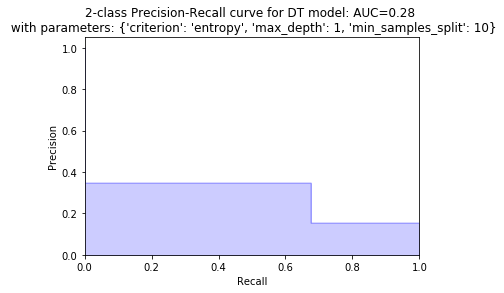

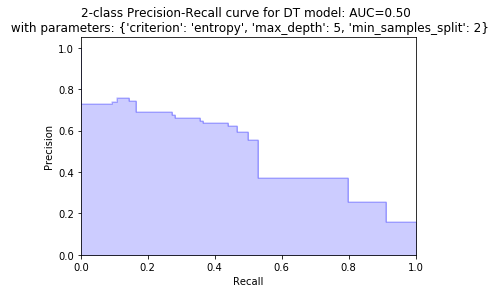

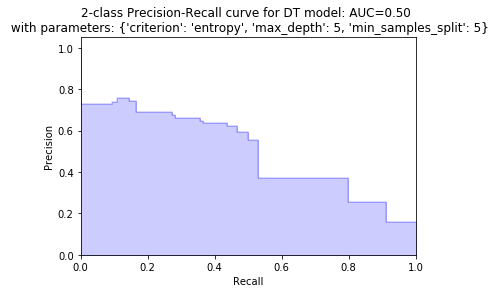

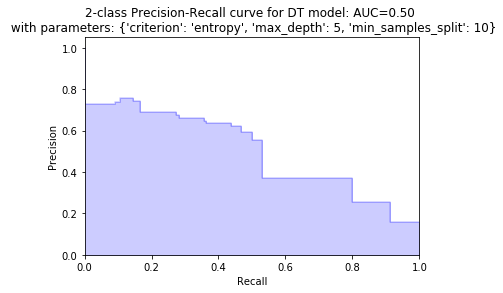

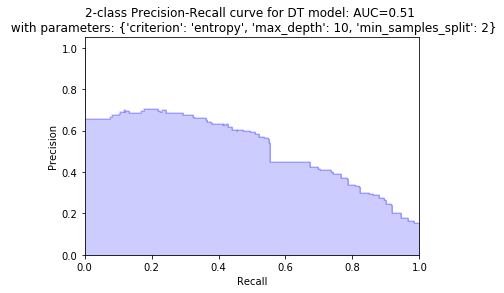

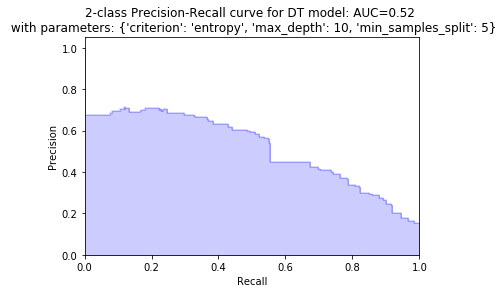

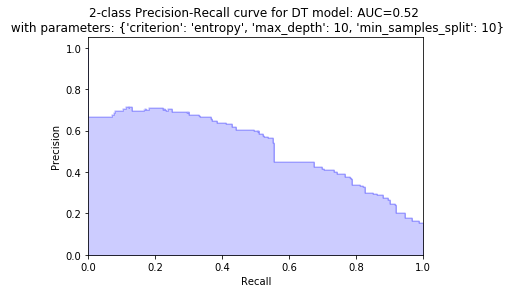

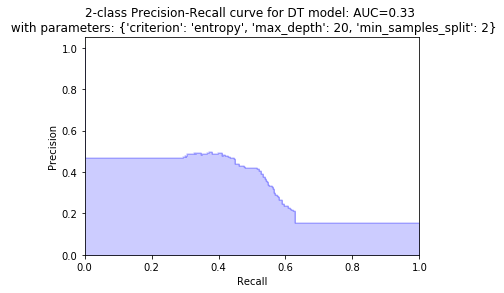

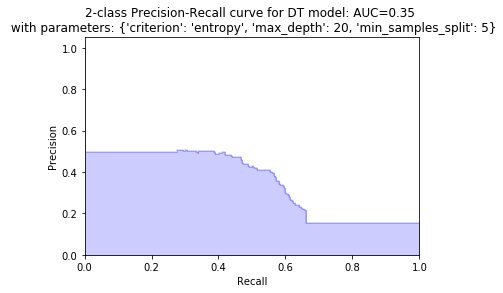

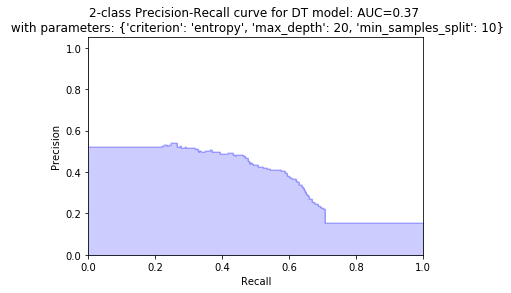

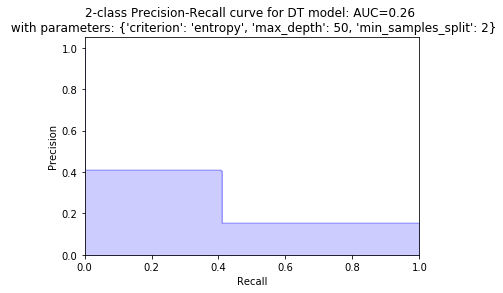

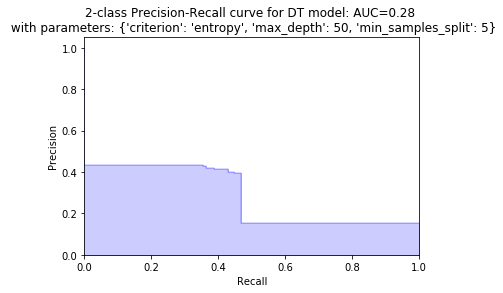

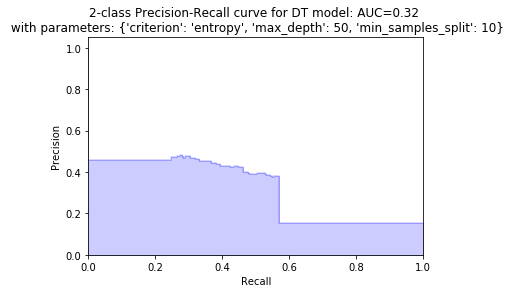

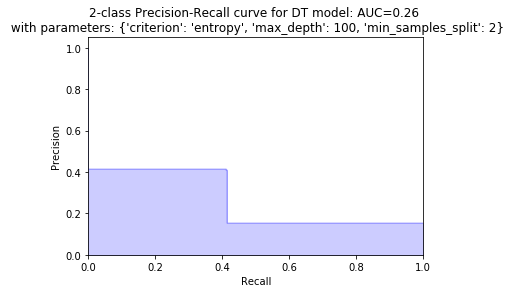

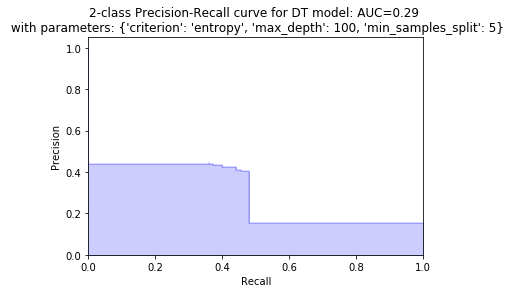

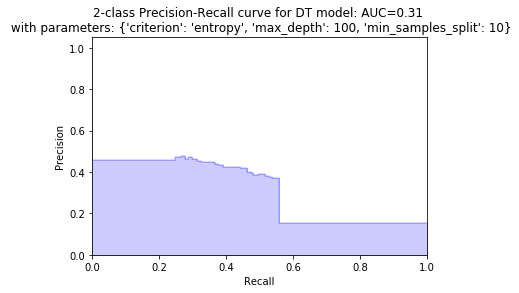

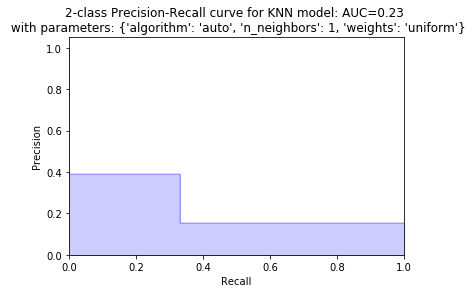

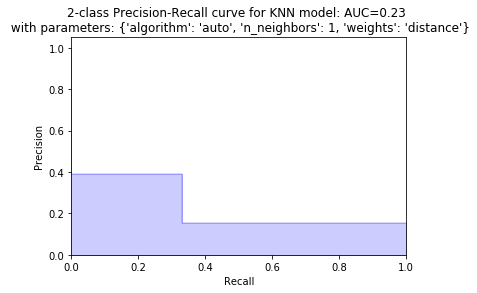

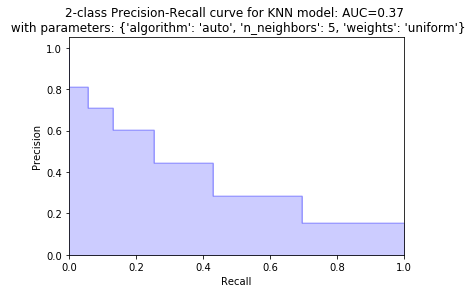

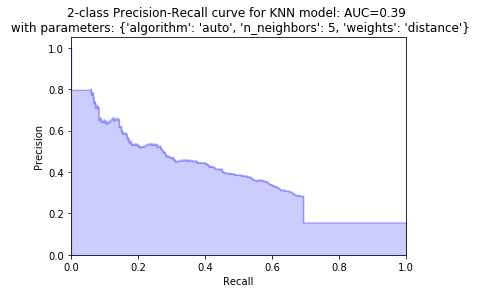

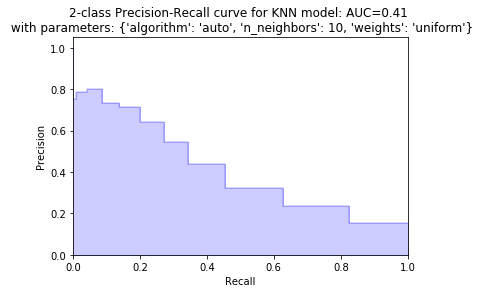

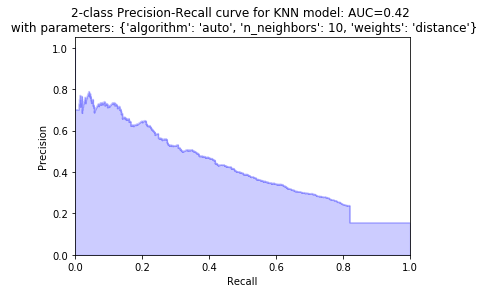

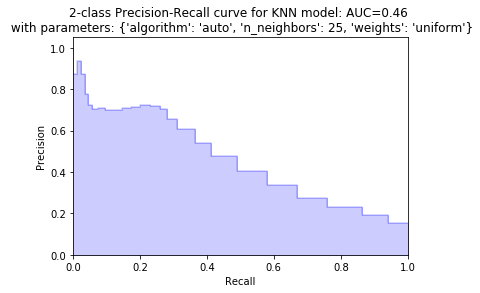

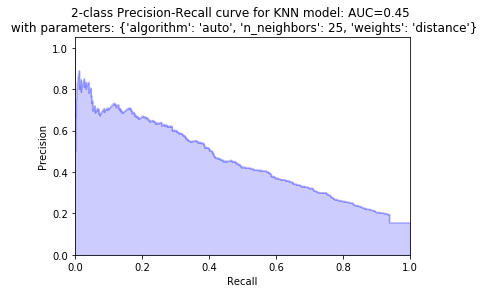

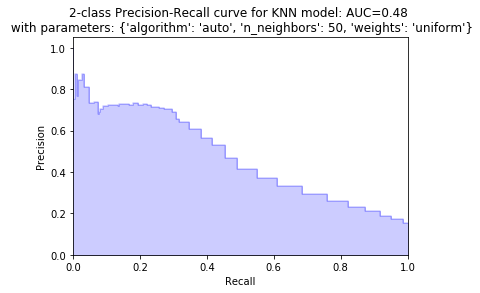

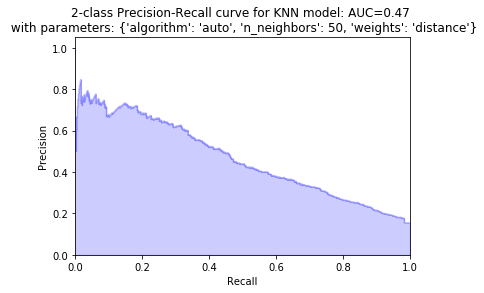

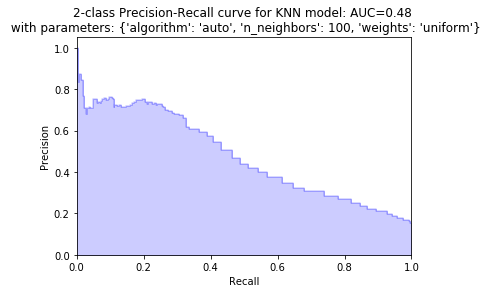

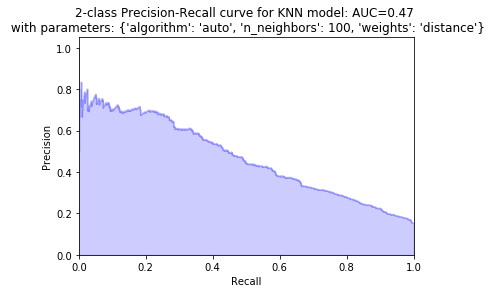

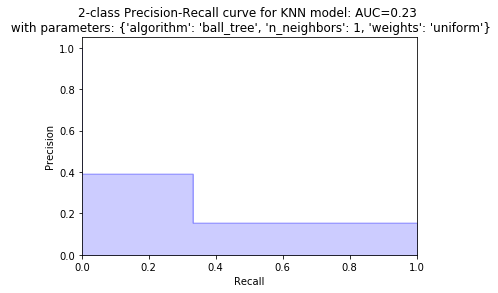

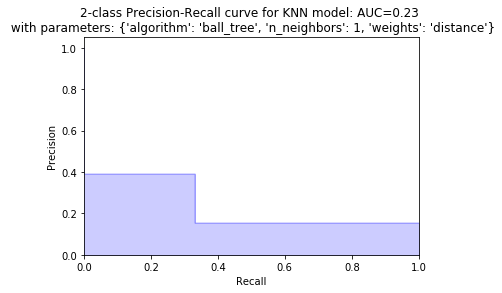

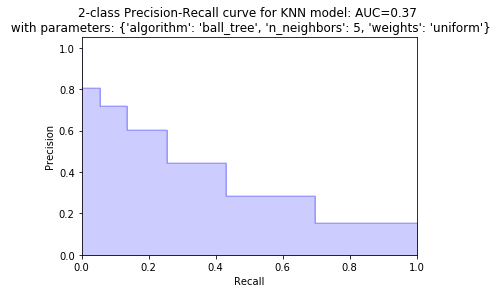

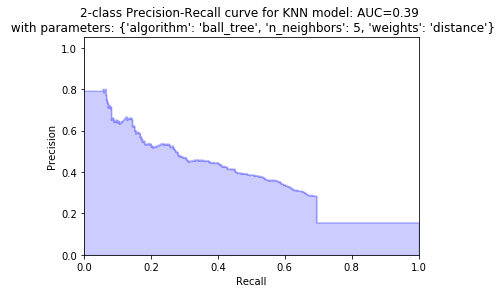

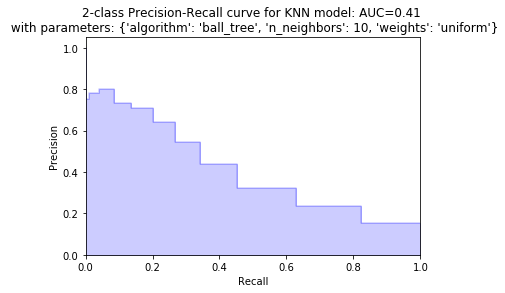

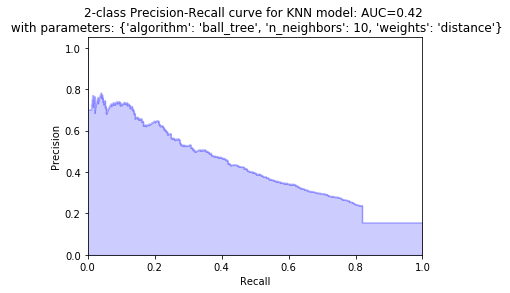

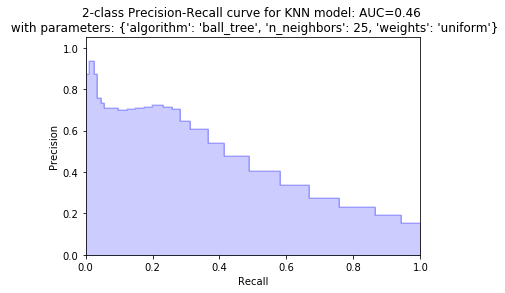

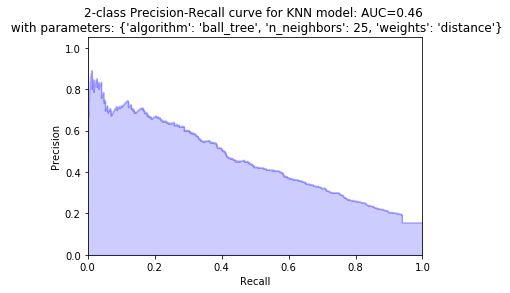

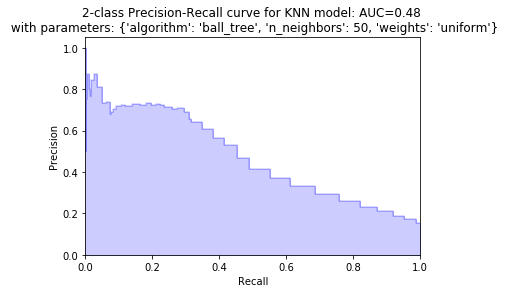

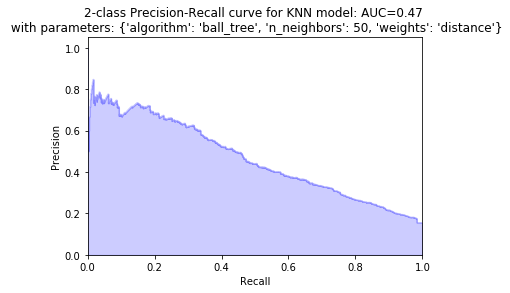

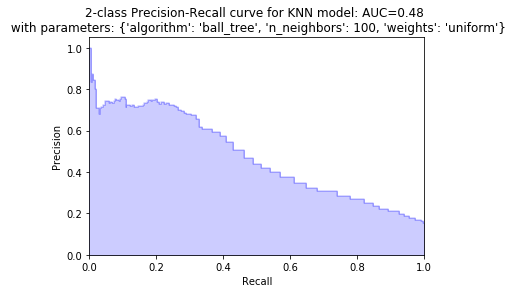

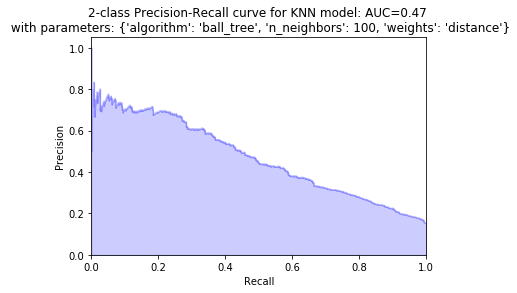

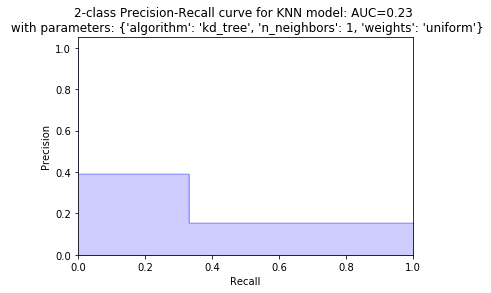

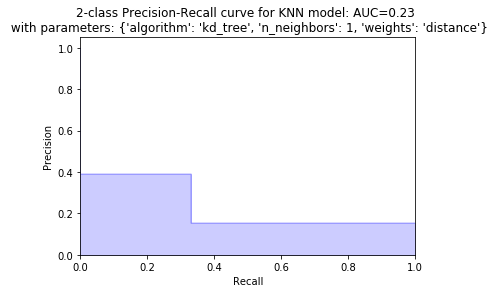

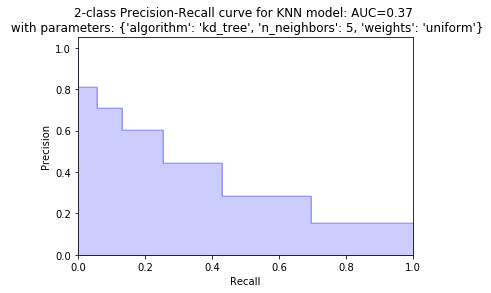

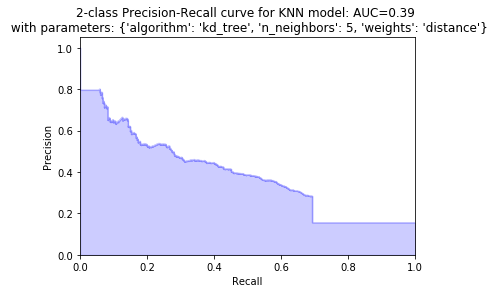

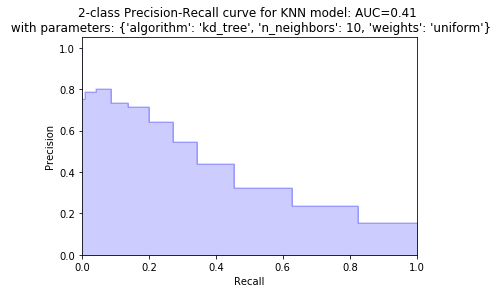

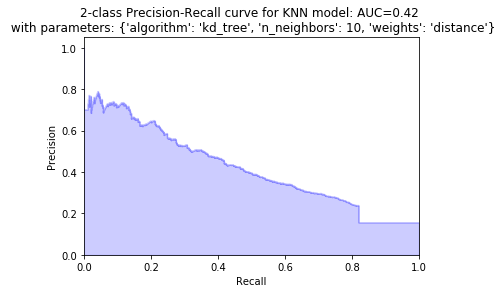

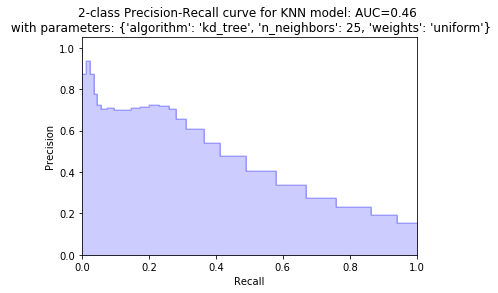

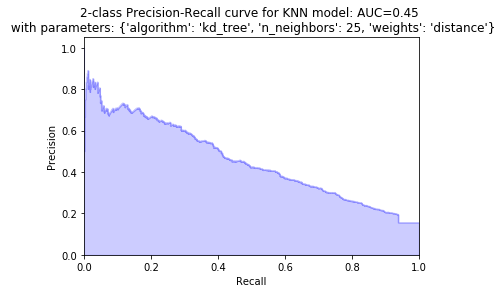

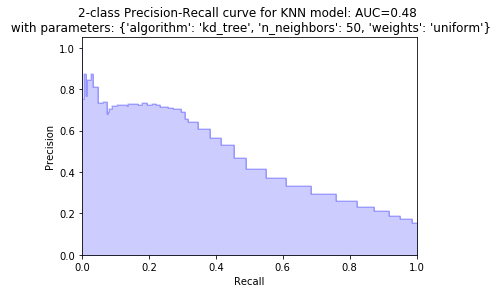

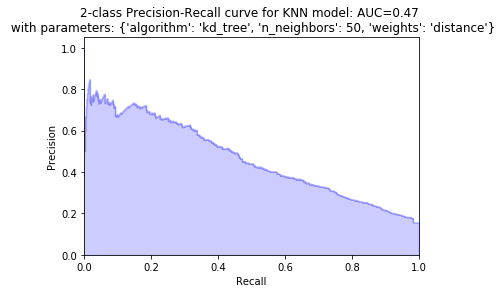

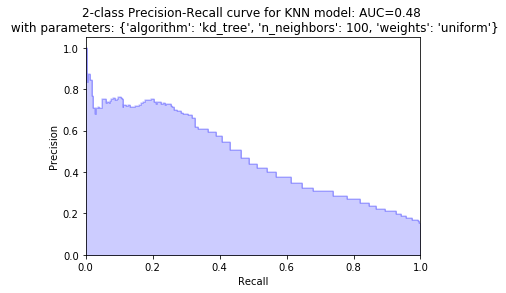

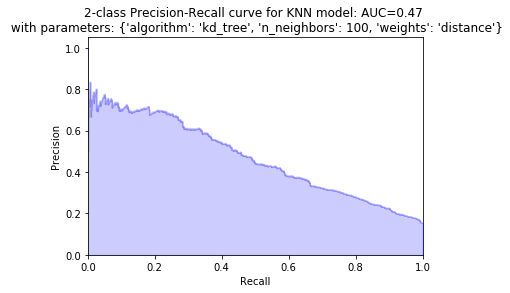

In [37]:
#### RUN THIS

#More machine learning methods can be added. However, that slows down the process,
# and requires more computational power
#This might take some time. Please wait.
new_dataframe = clf_loop(['RF', 'LR', 'DT', 'KNN'], x_train, x_test, y_train, y_test)

In [38]:
#### RUN THIS
### Converts dataframe to csv
new_dataframe.to_csv('final_output.csv', index=False)